In [273]:
import ROOT
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.interpolate import make_interp_spline
from tqdm import tqdm
from ROOT import TGraph
import awkward as ak
import uproot
import concurrent.futures
plt.style.use('science')
%run ../src/plotting_toolkit.py
%run ../src/dvmp_cross_section.py

In [365]:
PROJECT_NAME = "test4"
PROJECT_PATH = "/volatile/clas12/users/gmat/solid.data/coherent_deuteron_threshold/projects/"
TARGET_TYPE  = "d"
PLOT_DIR = f"./plots/{PROJECT_NAME}/cross_section"
PLOT_DIR_PNG = f"{PLOT_DIR}/png"
PLOT_DIR_PDF = f"{PLOT_DIR}/pdf"
try:
    os.makedirs(PLOT_DIR)
    os.makedirs(PLOT_DIR_PNG)
    os.makedirs(PLOT_DIR_PDF)
    print(f"Created directory: {PLOT_DIR}")
except:
    pass

In [366]:
def load_data(tree_type="all"):
    global bh_trees, photo_trees, electro_trees, beam_energy, integrated_luminosity, bh_events, days, photo_events, electro_events, luminosity

    bh_trees, photo_trees, electro_trees = get_uproots(PROJECT_NAME,PROJECT_PATH,tree_type)

    _, _, bh_events, _ = get_beamE_lumi_events_days(PROJECT_NAME,PROJECT_PATH,"bh")
    beam_energy, integrated_luminosity, photo_events, days  = get_beamE_lumi_events_days(PROJECT_NAME,PROJECT_PATH,"photoproduction")
    _, _, electro_events, _                               = get_beamE_lumi_events_days(PROJECT_NAME,PROJECT_PATH,"electroproduction")

    luminosity = get_lumi_from_integrated(integrated_luminosity,TARGET_TYPE,days)

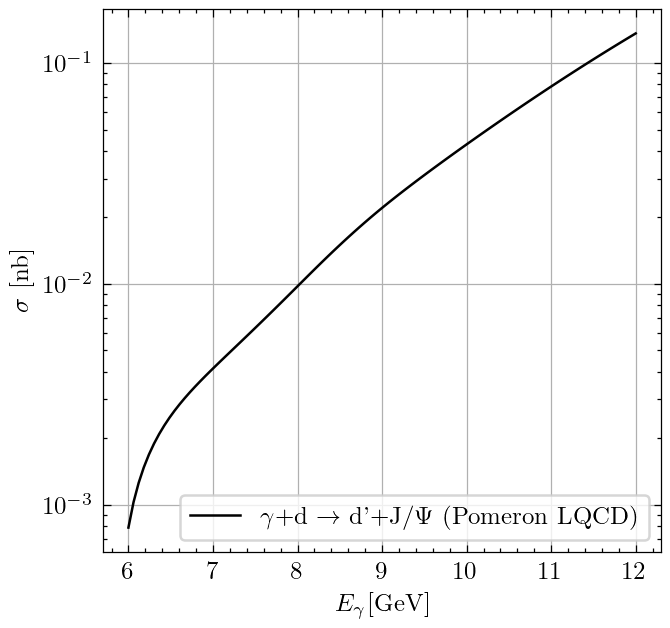

<Figure size 252x189 with 0 Axes>

In [367]:
# Generate Total Cross Section of Coherent J/Psi production off Deuteron
# Using Harry's Pomeron LQCD model

g_arr = np.array([6,7,8,9,10,12])
xsec_arr = np.array([xsec(g,"d") for g in g_arr])
X_Y_Spline = make_interp_spline(g_arr, xsec_arr)

npoints2=100
g_arr2 = np.linspace(6,12,npoints2)
xsec_arr2 = X_Y_Spline(g_arr2)
xsec_graph=TGraph(npoints2)
for i in range(npoints2):
    xsec_graph.SetPoint(i,g_arr2[i],xsec_arr2[i])
xsec_graph.SetLineColor(2)
theory_xsec_x = g_arr2
theory_xsec_y = xsec_arr2
plt.figure(dpi=180,figsize=(4,4))
plt.yscale("log")
plt.xlabel("$E_{\gamma}$[GeV]")
plt.ylabel("$\sigma$ [nb]")
plt.plot(g_arr2,xsec_arr2,label="$\gamma$+d $\\rightarrow$ d'+J/$\Psi$ (Pomeron LQCD)",color="k")
plt.grid()
plt.legend(frameon=True)
plt.show()
plt.savefig(f"{PLOT_DIR_PNG}/deuteron_total_coherent_xsec.png")
plt.savefig(f"{PLOT_DIR_PDF}/deuteron_total_coherent_xsec.pdf")

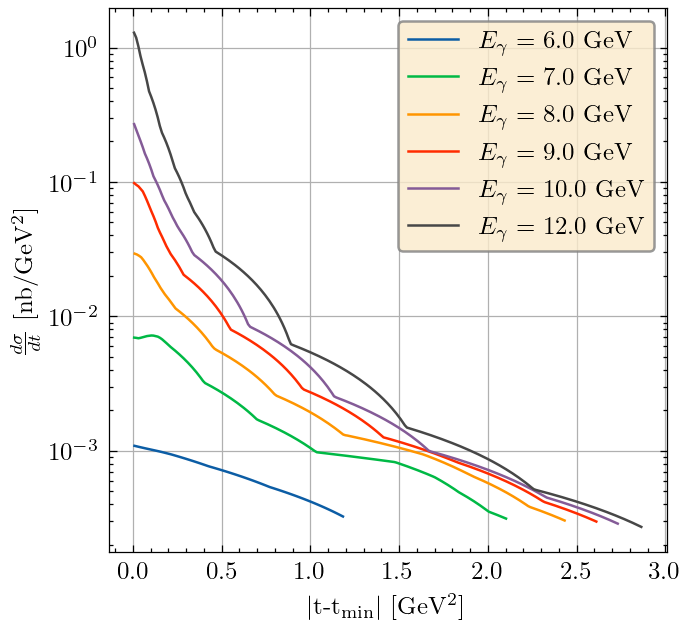

In [368]:
# Generate Differential Cross Section of Coherent J/Psi production off Deuteron
# Using Harry's Pomeron LQCD model

fig,axs=plt.subplots(1,1,dpi=180,figsize=(4,4))

g_arr = np.array([6,7,8,9,10,12])
for i in range(len(g_arr)):
    idx_E = np.abs(g_arr[i] - df_E_deuteron).argmin() # Find closest value to desired energy in the dsigmadt table
    E = df_E_deuteron[idx_E]
    dsdt = df_DSDT_deuteron[df_E_deuteron==E]
    kinematic_tmin = get_tmin(E,"d")
    t = df_T_deuteron[df_E_deuteron==E] + kinematic_tmin
    plt.errorbar(t,dsdt,label=f"$E_{{\gamma}}={E:.1f}$ GeV",fmt="-")

plt.xlabel("$|$t-t$_{\mathrm{min}}|$ [GeV$^{2}$]")
plt.ylabel("$\\frac{d\sigma}{dt}$ [nb/GeV$^{2}$]")
plt.grid()
legend=plt.legend(frameon=True,ncols=1)
legend.get_frame().set_facecolor('#FAEACB')  # slightly beige color
legend.get_frame().set_edgecolor('grey')  # grey border color
legend.get_frame().set_linewidth(1.0)  # thickness of border
plt.yscale("log")
plt.show()    

In [370]:
# Calculating the Coherent J/Psi Production Differential Cross Section from the Data
# Below, we define the dsdt plots to be created
# [Emin, Emax, tbins]
# ----------------------------------------------------------------
dsigmadt_arr = [
    [6,7,[0,0.125,0.25,0.4,0.6,0.75,1,1.2,1.5,1.75,2.25,3]],
    [7,7.33,[0,0.2,0.45,0.6,1,1.25,1.5,2,2.25,3]],
    [7.33,7.66,[0,0.2,0.45,0.6,1,1.25,1.5,2,2.25,3]],
    [7.66,8,[0,0.1,0.2,0.3,0.4,0.5,0.6,1,1.5,3]],
    [8,8.4,[0,0.1,0.2,0.3,0.4,0.5,0.6,1,3]],
    [8.4,8.8,[0,0.1,0.2,0.3,0.4,0.5,0.6,1,3]]
]

# ----------------------------------------------------------------------------------
# Load data and corresponding TTrees
# Create multidimensional lists
# fills  --> Number of times the multidim bin was filled
# counts --> Expected counts within acceptance 
# diffxsec_counts --> Counts over several factors (e.g. decay_weight, psf, flux) --> dsigma/dt
# Eacc      --> Accumulates energy for each event


def analyze_trees(trees, version, make_analysis_cuts, dsigmadt_arr, integrated_luminosity, photo_events):
    
    fills = [[0 for _ in range(len(t_bins) - 1)] for _, _, t_bins in dsigmadt_arr]
    counts = [[0 for _ in range(len(t_bins) - 1)] for _, _, t_bins in dsigmadt_arr]
    diffxsec_counts = [[0 for _ in range(len(t_bins) - 1)] for _, _, t_bins in dsigmadt_arr]
    Eacc  =  [0 for _ in range(len(dsigmadt_arr))]
    
    for tree in trees:
        
        data = tree.arrays(["smear_gammaE", "gammaE", "smear_Q2", "smear_m_vm","smear_t","t","weight","decay_weight","J","acc_ePlus","acc_hOut","psf","flux","acc_eMinus"],library="np")
        event_E = (data["smear_gammaE"] if make_analysis_cuts else data["gammaE"])
        event_Q2 = data["smear_Q2"]
        event_M = data["smear_m_vm"]
        event_t = np.abs((data["smear_t"] if make_analysis_cuts else data["t"]) - get_tmin(event_E,"d"))
        weight = data["weight"]
        decay_weight = data["decay_weight"]
        J = data["J"] # Jacobian
        acc_ePlus = data["acc_ePlus"]
        acc_eMinus = data["acc_eMinus"]
        acc_hOut = data["acc_hOut"]
        acc = acc_ePlus*acc_eMinus*acc_hOut
        psf = data["psf"]
        flux = data["flux"]



        # Vectorized conditions
        cut_conditions = (np.abs(event_Q2) < 0.02) * (np.abs(event_M - 3.1) < 0.1) * (acc>0)
        cut_conditions = cut_conditions if make_analysis_cuts else np.ones_like(cut_conditions, dtype=bool)

        for i, (Emin, Emax, t_bins) in enumerate(dsigmadt_arr):
            E_condition = (Emin <= event_E) & (event_E < Emax)
            for j, (tmin, tmax) in enumerate(zip(t_bins[:-1], t_bins[1:])):
                t_condition = (tmin < event_t) & (event_t <= tmax)
                full_condition = cut_conditions & E_condition & t_condition
                fills[i][j] += np.sum(full_condition)
                counts_ = full_condition * weight*decay_weight*psf*flux* (integrated_luminosity / photo_events)
                counts[i][j] += np.sum(counts_)
                diffxsec_counts[i][j] += np.sum(full_condition * weight/J)
                Eacc[i] += np.sum(event_E * counts_)

    return fills, counts, diffxsec_counts, Eacc

def get_counts_parallel(version, make_analysis_cuts, num_batches):
    if make_analysis_cuts:
        data = load_data("acc")
    else:
        data = load_data("all")
    
    if version == "photo":
        trees = photo_trees
    elif version == "electro":
        trees = electro_trees
    
    # Create tree chunks for parallel processing
    n = len(trees)
    chunk_size = n // num_batches
    remainder = n % num_batches

    tree_chunks = [
        trees[i * chunk_size + min(i, remainder):(i + 1) * chunk_size + min(i + 1, remainder)]
        for i in range(num_batches)
    ]
    #analyze_trees(tree_chunks[0], version, make_analysis_cuts, dsigmadt_arr, integrated_luminosity, photo_events)
    with concurrent.futures.ProcessPoolExecutor() as executor:
        futures = [
            executor.submit(
                analyze_trees,
                chunk, 
                version, 
                make_analysis_cuts, 
                dsigmadt_arr, 
                integrated_luminosity, 
                photo_events
            )
            for chunk in tree_chunks
        ]

        results = [future.result() for future in concurrent.futures.as_completed(futures)]
    
    # Combine results from all chunks
    fills_combined = ak.sum([ak.Array(result[0]) for result in results], axis=0)
    counts_combined = ak.sum([ak.Array(result[1]) for result in results], axis=0)
    diffxsec_counts_combined = ak.sum([ak.Array(result[2]) for result in results], axis=0)
    Eacc_combined = ak.sum([ak.Array(result[3]) for result in results], axis=0) / ak.sum(counts_combined, axis=1)

    print("Done!")
    return fills_combined, counts_combined, diffxsec_counts_combined, Eacc_combined

photo_cut_df = get_counts_parallel(version="photo",make_analysis_cuts=True,num_batches=25)
photo_df     = get_counts_parallel(version="photo",make_analysis_cuts=False,num_batches=25)

electro_cut_df = get_counts_parallel(version="electro",make_analysis_cuts=True,num_batches=25)
electro_df     = get_counts_parallel(version="electro",make_analysis_cuts=False,num_batches=25)

Done!
Done!
Done!
Done!


In [371]:
# Define the fit function
def func(x, A, b):
    return A * np.exp(-b * x)

def get_xsec_integrate(dsigmadt_arr, cut_df, df):
    
    fills_acc, counts_acc, diffxsec_counts_acc, E_avg_acc = cut_df
    fills_all, counts_all, diffxsec_counts_all, E_avg_all = df
    
    xsec_integrate = []
    xsec_integrate_err = []
    
    for i, (Emin, Emax, t_bins) in enumerate(dsigmadt_arr):
        x = 0.5 * (np.array(t_bins[:-1]) + np.array(t_bins[1:]))
        y = np.array(diffxsec_counts_all[i])/np.array(fills_all[i])
        yields = np.array(counts_acc[i])


        # Filter out data points where yields are zero
        mask = yields != 0

        x_filtered = x[mask]
        y_filtered = y[mask]
        yerr_filtered = y_filtered/np.sqrt(yields[mask])
        
        # Fit the function to the data
        popt, pcov = curve_fit(func, x_filtered, y_filtered, sigma=yerr_filtered, p0=[1, 1], absolute_sigma=True)
        
        A, b = popt
        dA, db = np.sqrt(np.diag(pcov))
        
        xsec_integrate.append(A/b)
        xsec_integrate_err.append(np.sqrt(dA**2/b**2+db**2*A**2/b**4))
        
    return xsec_integrate, xsec_integrate_err

In [372]:
def plot_Ebinned_yields(dsigmadt_arr, cut_df, df, production_type=""):
    
    fills_acc, counts_acc, diffxsec_counts_acc, E_avg_acc = cut_df
    fills_all, counts_all, diffxsec_counts_all, E_avg_all = df


    # Plotting the yields from simulated
    # ----------------------------------------|----------------------------------------
    fig, axs = plt.subplots(2, 3, dpi=180, figsize=(6, 4), sharex=True, sharey=True)
    fig.subplots_adjust(hspace=0, wspace=0)
    axs = axs.flatten()

    fig.add_subplot(111, frameon=False)
    # hide tick and tick label of the big axis
    plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
    plt.xlabel("$|$t-t$_{\mathrm{min}}|$ [GeV$^{2}$]")
    plt.ylabel("Event Yields",labelpad=12)
    for i, (Emin, Emax, t_bins) in enumerate(dsigmadt_arr):
        x = 0.5 * (np.array(t_bins[:-1]) + np.array(t_bins[1:]))
        y = np.array(counts_acc[i])
        yerr = np.sqrt(y)

        mask = y!=0
        x = x[mask]
        y = y[mask]
        yerr = yerr[mask]

        axs[i].errorbar(x, y, yerr=yerr, fmt="k.",capsize=2)
        axs[i].grid()
        axs[i].text(0.95, 0.95, f"{Emin:.2f} $ <$ E$_{{\gamma}}<$ {Emax:.2f} [GeV]", transform=axs[i].transAxes, fontsize=6, horizontalalignment='right',
                    verticalalignment='top', bbox=dict(boxstyle='round', facecolor='beige', edgecolor='grey'))

    axs[0].text(0.95,0.825,f"SoLID J/$\Psi$ {production_type}",transform=axs[0].transAxes, fontsize=5.5, horizontalalignment='right',verticalalignment='top',fontweight='bold')

    plt.show()

In [373]:
# Plotting the differential cross section w/ errors from accepted yields
# 1.) Get differential cross section by calculating the average dsdt per t-bin (use 4pi acceptance)
# 2.) Use yields N from the SoLID acceptance to determine error bars
# --------------------------------------------------------------------------------

def plot_Ebinned_dsdt(dsigmadt_arr, cut_df, df, production_type=""):
    
    fills_acc, counts_acc, diffxsec_counts_acc, E_avg_acc = cut_df
    fills_all, counts_all, diffxsec_counts_all, E_avg_all = df

    # Define the fit function
    def func(x, A, b):
        return A * np.exp(-b * x)

    fig, axs = plt.subplots(2, 3, dpi=180, figsize=(6, 4), sharex=True, sharey=True)
    fig.subplots_adjust(hspace=0, wspace=0)
    axs = axs.flatten()

    fig.add_subplot(111, frameon=False)
    # hide tick and tick label of the big axis
    plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)

    plt.xlabel("$|$t-t$_{\mathrm{min}}|$ [GeV$^{2}$]")
    plt.ylabel("$\\frac{d\sigma}{dt}$ [nb/GeV$^{2}$]",labelpad=20)

    
    for i, (Emin, Emax, t_bins) in enumerate(dsigmadt_arr):
        x = 0.5 * (np.array(t_bins[:-1]) + np.array(t_bins[1:]))
        y = np.array(diffxsec_counts_all[i])/np.array(fills_all[i])
        yields = np.array(counts_acc[i])


        # Filter out data points where yields are zero
        mask = yields != 0

        x_filtered = x[mask]
        y_filtered = y[mask]
        yerr_filtered = y_filtered/np.sqrt(yields[mask])
        axs[i].errorbar(x_filtered, y_filtered, yerr=yerr_filtered, fmt="k.", capsize=2)
        axs[i].set_yscale('log')
        axs[i].grid()


        # Fit the function to the data
        popt, pcov = curve_fit(func, x_filtered, y_filtered, sigma=yerr_filtered, p0=[1, 1], absolute_sigma=True)
        x_fit = np.linspace(0, 1.85, 1000)
        y_fit = func(x_fit, *popt)
        axs[i].plot(x_fit, y_fit, 'r--', label='Fit')

        # Add text box with fit parameters and uncertainties
        A, b = popt
        dA, db = np.sqrt(np.diag(pcov))
        text_label = (f"{Emin:.2f} $ <$ E$_{{\gamma}}<$ {Emax:.2f} [GeV]\n"
                      f"A = {A:.2f} ± {dA:.2f}\n"
                      f"b = {b:.2f} ± {db:.2f}")
        axs[i].text(0.95, 0.95, text_label, transform=axs[i].transAxes, fontsize=6, horizontalalignment='right',
                    verticalalignment='top', bbox=dict(boxstyle='round', facecolor='beige', edgecolor='grey'))

        axs[i].set_ylim(0.00005,0.2)
        axs[i].set_xlim(-0.05,1.85)
        
    axs[0].text(0.95,0.75,f"SoLID J/$\Psi$ {production_type}",transform=axs[0].transAxes, fontsize=5.5, horizontalalignment='right',verticalalignment='top',fontweight='bold')
    plt.show()

In [374]:
#Plot Total Cross Section as a Function of Egamma for the Experiment
# fix_values --> Use true theoretical y value for the total cross section
def plot_Ebinned_totalxsec(dsigmadt_arr, cut_df,df,production_type="",do_xerr=True, fix_values=False):
    fills_acc, counts_acc, diffxsec_counts_acc, E_avg_acc = cut_df
    fills_all, counts_all, diffxsec_counts_all, E_avg_all = df
    
    Emid = E_avg_acc
    fig,axs = plt.subplots(1,1,dpi=180,figsize=(4,4))
    
    if fix_values:
        _,xsec_integrate_err = get_xsec_integrate(dsigmadt_arr,cut_df,df)
        xsec_integrate = X_Y_Spline(Emid)
        do_xerr=False
    else:
        xsec_integrate, xsec_integrate_err = get_xsec_integrate(dsigmadt_arr,cut_df,df)
    
    if do_xerr:
        axs.errorbar(Emid,xsec_integrate,xerr = [Emid-Emin,Emax-Emid], yerr=xsec_integrate_err,fmt="m.",capsize=2,label=f"SoLID {production_type}")
    else:
        axs.errorbar(Emid,xsec_integrate, yerr=xsec_integrate_err,fmt="m.",capsize=2,label=f"SoLID {production_type}")
    axs.plot(theory_xsec_x,theory_xsec_y,"k--",label="Pomeron LQCD")
    axs.legend(frameon=True)
    axs.grid()
    axs.set_xlim(5.8,9)
    axs.set_ylim(0.0005,0.08)
    axs.set_yscale("log")
    
def plot_Ebinned_totalxsec_both(dsigmadt_arr, photo_cut_df,photo_df,electro_cut_df,electro_df,do_xerr=True, fix_values=False):
    
    fig,axs = plt.subplots(1,1,dpi=180,figsize=(4,4))
    for cut_df, df, production_type in zip([photo_cut_df,electro_cut_df],[photo_df,electro_df],["Photoproduction","Electroproduction"]):

        fills_acc, counts_acc, diffxsec_counts_acc, E_avg_acc = cut_df
        fills_all, counts_all, diffxsec_counts_all, E_avg_all = df
        
        Emid = np.array(E_avg_acc)
        
        if fix_values:
            _,xsec_integrate_err = get_xsec_integrate(dsigmadt_arr,cut_df,df)
            xsec_integrate = X_Y_Spline(Emid)
            do_xerr=False
            if production_type=="Photoproduction":
                Emid+=-0.035
            else:
                Emid+=0.035
        else:
            xsec_integrate, xsec_integrate_err = get_xsec_integrate(dsigmadt_arr,cut_df,df)
            

        
        xsec_integrate, xsec_integrate_err = get_xsec_integrate(dsigmadt_arr,cut_df,df)
        
        
        if do_xerr:
            axs.errorbar(Emid,xsec_integrate,xerr = [Emid-Emin,Emax-Emid], yerr=xsec_integrate_err,fmt=("b" if production_type=="Photoproduction" else "r")+".",capsize=1.5,label=f"SoLID {production_type}")
        else:
            axs.errorbar(Emid,xsec_integrate, yerr=xsec_integrate_err,fmt=("b" if production_type=="Photoproduction" else "r")+".",capsize=1.5,label=f"SoLID {production_type}")
    axs.plot(theory_xsec_x,theory_xsec_y,"k--",label="Pomeron LQCD")
    axs.legend(frameon=True)
    axs.grid()
    axs.set_xlim(5.8,9)
    axs.set_ylim(0.0005,0.08)
    axs.set_yscale("log")
    
    plt.show()



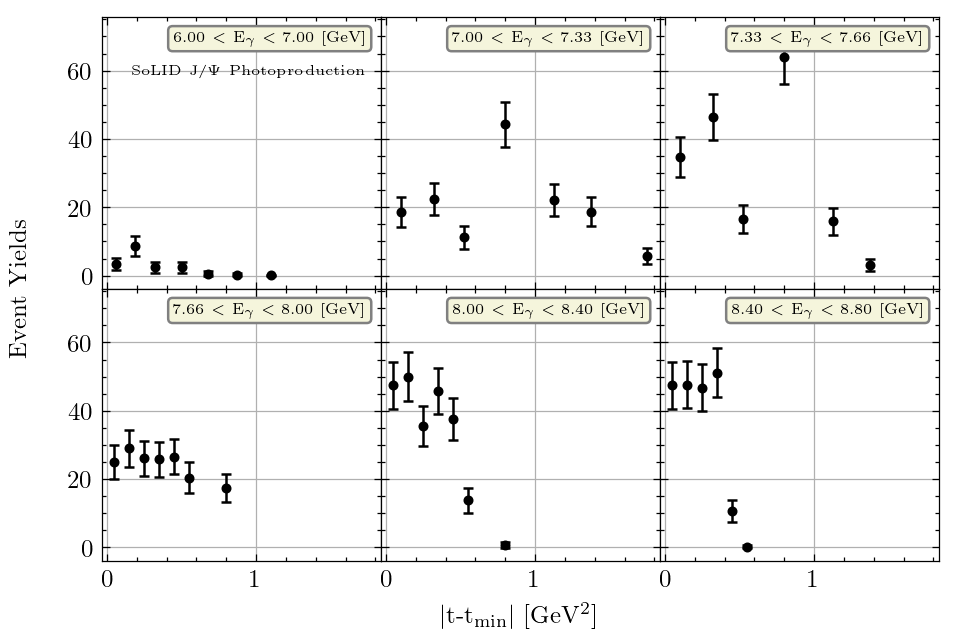

<ipython-input-373-575ce803b39b>:29: RuntimeWarning: invalid value encountered in divide
  y = np.array(diffxsec_counts_all[i])/np.array(fills_all[i])


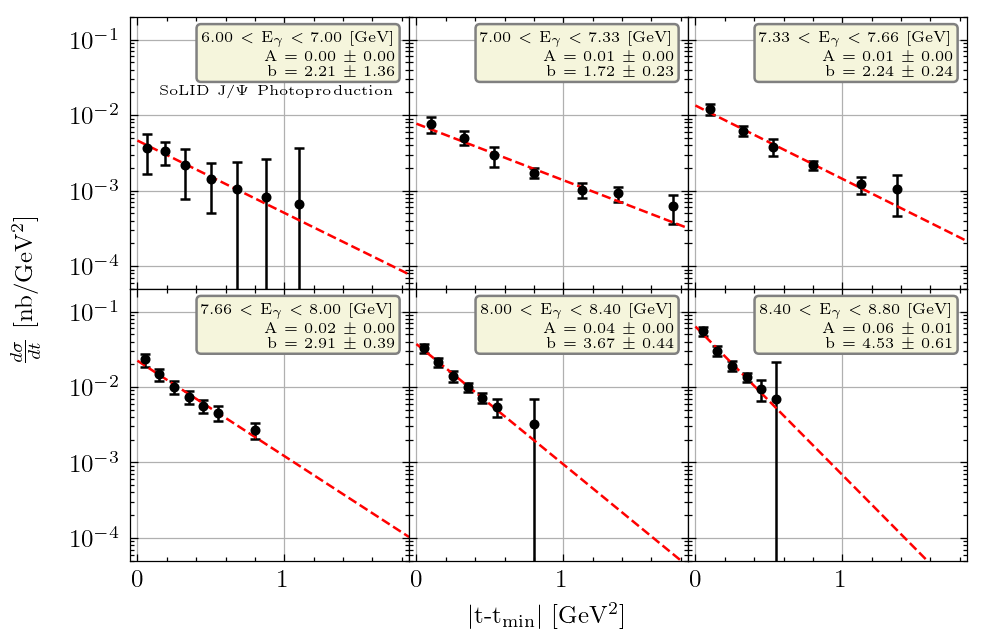

<ipython-input-371-63e4fe8b65f7>:15: RuntimeWarning: invalid value encountered in divide
  y = np.array(diffxsec_counts_all[i])/np.array(fills_all[i])


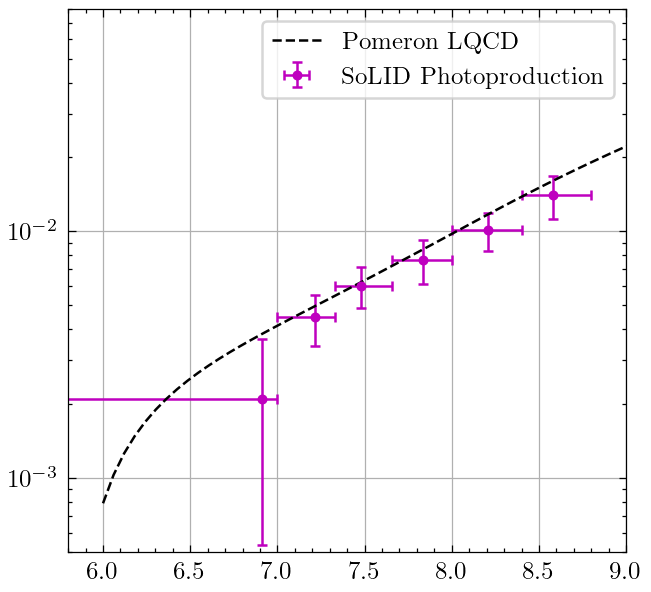

In [375]:
plot_Ebinned_yields(dsigmadt_arr, photo_cut_df, photo_df,"Photoproduction")
plot_Ebinned_dsdt(dsigmadt_arr, photo_cut_df, photo_df,"Photoproduction")
plot_Ebinned_totalxsec(dsigmadt_arr, photo_cut_df, photo_df,"Photoproduction")

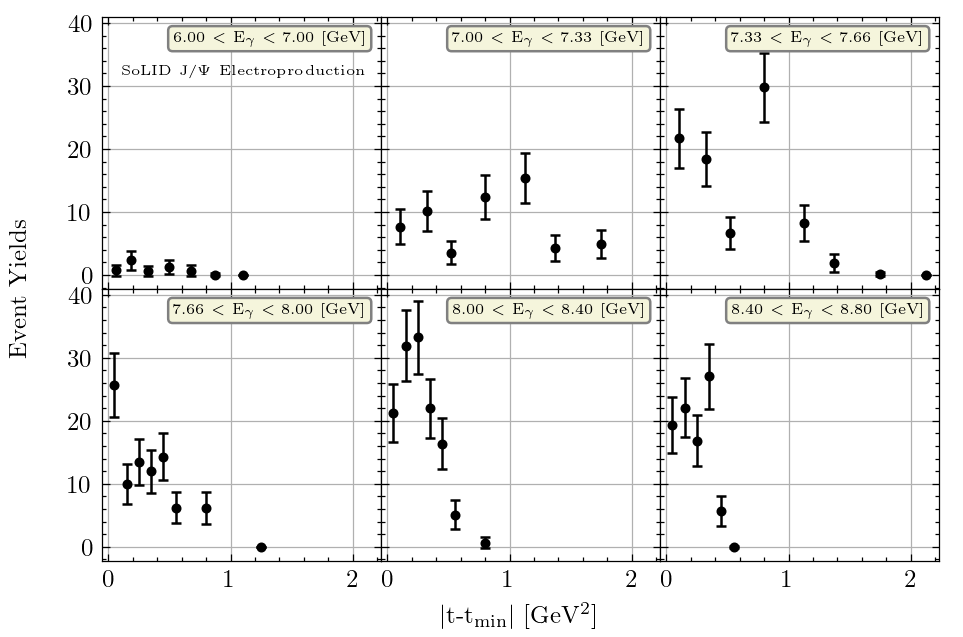

<ipython-input-373-575ce803b39b>:29: RuntimeWarning: invalid value encountered in divide
  y = np.array(diffxsec_counts_all[i])/np.array(fills_all[i])


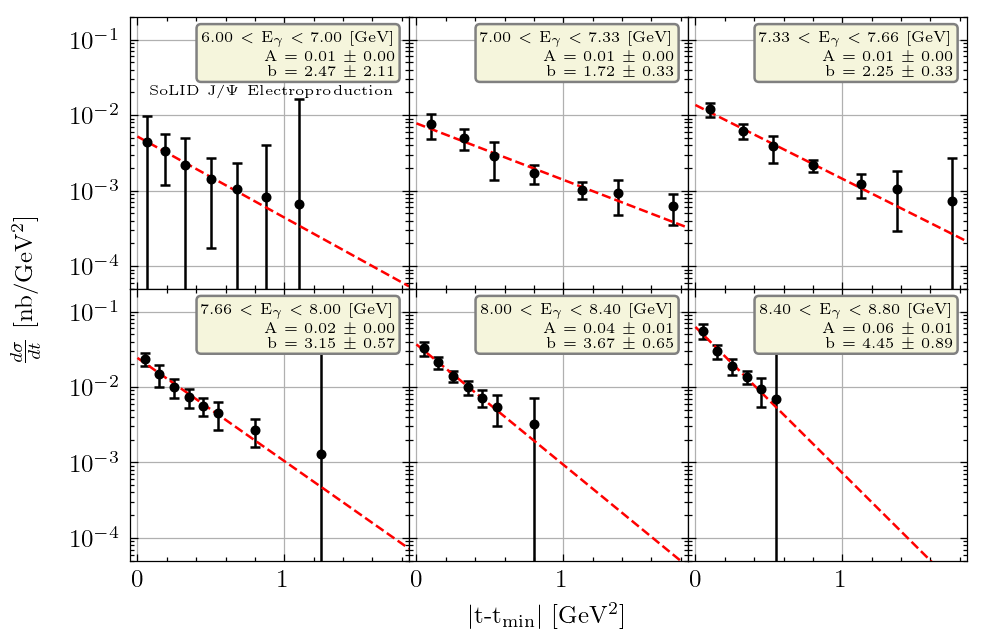

<ipython-input-371-63e4fe8b65f7>:15: RuntimeWarning: invalid value encountered in divide
  y = np.array(diffxsec_counts_all[i])/np.array(fills_all[i])


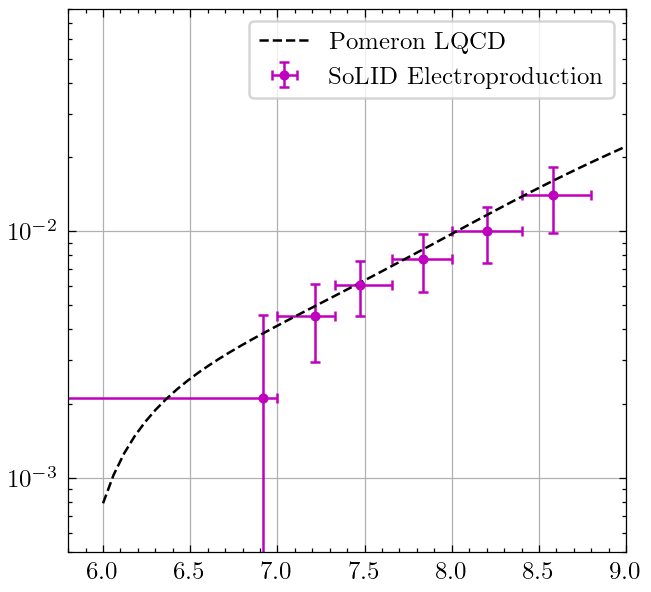

In [376]:
plot_Ebinned_yields(dsigmadt_arr, electro_cut_df, electro_df,"Electroproduction")
plot_Ebinned_dsdt(dsigmadt_arr, electro_cut_df, electro_df,"Electroproduction")
plot_Ebinned_totalxsec(dsigmadt_arr, electro_cut_df, electro_df,"Electroproduction")

<ipython-input-371-63e4fe8b65f7>:15: RuntimeWarning: invalid value encountered in divide
  y = np.array(diffxsec_counts_all[i])/np.array(fills_all[i])


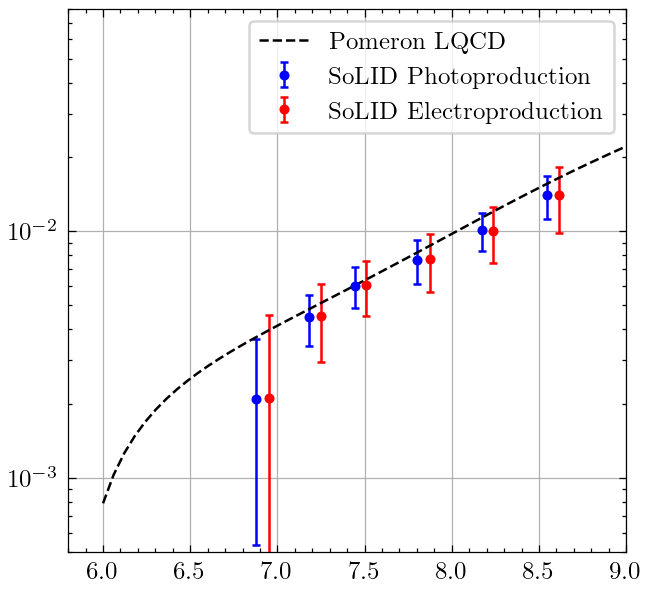

In [378]:
plot_Ebinned_totalxsec_both(dsigmadt_arr,photo_cut_df,photo_df,electro_cut_df,electro_df,fix_values=True)

In [251]:
import concurrent.futures
from functools import partial

def analyze_tree_chunk(chunk_start, chunk_size, tree, version, make_analysis_cuts, dsigmadt_arr, integrated_luminosity, photo_events):
    
    fills = [[0 for _ in range(len(t_bins) - 1)] for _, _, t_bins in dsigmadt_arr]
    counts = [[0 for _ in range(len(t_bins) - 1)] for _, _, t_bins in dsigmadt_arr]
    diffxsec_counts = [[0 for _ in range(len(t_bins) - 1)] for _, _, t_bins in dsigmadt_arr]
    Eacc  =  [0 for _ in range(len(dsigmadt_arr))]
    
    chunk_end = chunk_start + chunk_size
    for idx_, iev in enumerate(tree):
        if idx_ <= chunk_start or idx_ > chunk_end:
            continue
            
        if make_analysis_cuts:
            event_E = iev.smear_q.E()
            event_t = abs(iev.smear_t - get_tmin(event_E,"d"))
        else:
            event_E = iev.q.E()
            event_t = abs(iev.t - get_tmin(event_E,"d"))

        # Check which E bin the event falls in
        for i, (Emin, Emax, t_bins) in enumerate(dsigmadt_arr):
            if Emin <= event_E < Emax:
                # Check which t bin the event falls in
                for j, (tmin, tmax) in enumerate(zip(t_bins[:-1], t_bins[1:])):
                    if tmin < event_t <= tmax:
                        # Check other conditions here. If they are satisfied:
                        cut_condition = (
                            abs(iev.smear_q.M2()) < 0.02 and
                            abs(iev.smear_VM.M() - 3.1) < 0.1 and
                            iev.acc_eMinus and iev.acc_ePlus and iev.acc_hOut
                        ) if make_analysis_cuts else True
                        if cut_condition:
                            fills[i][j] += 1
                            counts[i][j] += iev.weight * iev.decay_weight * iev.psf * iev.flux * (integrated_luminosity / photo_events)
                            diffxsec_counts[i][j] += iev.weight / iev.J # The iev.weight is written as dsigma/dcth so we use a jacobian to convert to dsigma/dt
                            Eacc[i] += event_E
                        break

    return fills, counts, diffxsec_counts, Eacc

def get_counts_parallel(version, make_analysis_cuts, num_batches):
    if make_analysis_cuts:
        data = load_data("acc")
    else:
        data = load_data("all")
        
    if version == "photo":
        tree = photo_trees
    elif version == "electro":
        tree = electro_trees

    # Determine the size of each chunk
    chunk_size = tree.GetEntries() // num_batches

    # Use ProcessPoolExecutor to process tree in parallel
    with concurrent.futures.ProcessPoolExecutor() as executor:
        # Create a list of arguments for each chunk
        futures = [
            executor.submit(
                analyze_tree_chunk,
                i * chunk_size, 
                chunk_size, 
                tree, 
                version, 
                make_analysis_cuts, 
                dsigmadt_arr, 
                integrated_luminosity, 
                photo_events
            ) 
            for i in range(num_batches)
        ]
        
        results = [future.result() for future in concurrent.futures.as_completed(futures)]

    # Combine results from all chunks
    fills_combined = ak.sum([result[0] for result in results], axis=0)
    counts_combined = ak.sum([result[1] for result in results], axis=0)
    diffxsec_counts_combined = ak.sum([result[2] for result in results], axis=0)
    Eacc_combined = ak.sum([result[3] for result in results], axis=0) / ak.sum(fills_combined, axis=1)

    return fills_combined, counts_combined, diffxsec_counts_combined, Eacc_combined


In [220]:
fills_combined, counts_combined, diffxsec_counts_combined, Eacc_combined = get_counts_parallel("photo",True,10)

/w/hallb-scshelf2102/clas12/users/gmat/SoLIDThresholdPhysics/src/dvmp_cross_section.py:153: RuntimeWarning: invalid value encountered in sqrt
  p2 = np.sqrt(np.power(W * W - m3_2 - m4_2,2) - 4.0 * m3_2 * m4_2) / (2.0 * W);
/w/hallb-scshelf2102/clas12/users/gmat/SoLIDThresholdPhysics/src/dvmp_cross_section.py:153: RuntimeWarning: invalid value encountered in sqrt
  p2 = np.sqrt(np.power(W * W - m3_2 - m4_2,2) - 4.0 * m3_2 * m4_2) / (2.0 * W);
/w/hallb-scshelf2102/clas12/users/gmat/SoLIDThresholdPhysics/src/dvmp_cross_section.py:153: RuntimeWarning: invalid value encountered in sqrt
  p2 = np.sqrt(np.power(W * W - m3_2 - m4_2,2) - 4.0 * m3_2 * m4_2) / (2.0 * W);
/w/hallb-scshelf2102/clas12/users/gmat/SoLIDThresholdPhysics/src/dvmp_cross_section.py:153: RuntimeWarning: invalid value encountered in sqrt
  p2 = np.sqrt(np.power(W * W - m3_2 - m4_2,2) - 4.0 * m3_2 * m4_2) / (2.0 * W);
/w/hallb-scshelf2102/clas12/users/gmat/SoLIDThresholdPhysics/src/dvmp_cross_section.py:153: RuntimeWarning: 

In [227]:
diffxsec_counts_combined - diffxsec_counts_acc

<Array [[2.78e-17, 0, -1.39e-17, ..., 0, 0, 0], ...] type='6 * var * float64'>

<Array [[3.25, 4.59, 1.67, 2.35, ..., 0, 0, 0], ...] type='6 * var * float64'>

treeAcc
tree


In [ ]:

# def get_counts(version,make_analysis_cuts):
#     if make_analysis_cuts:
#         load_data("acc")
#     else:
#         load_data("all")
        
#     if version=="photo":
#         tree = photo_trees
#     elif version=="electro":
#         tree = electro_trees

    
#     fills = [[0 for _ in range(len(t_bins) - 1)] for _, _, t_bins in dsigmadt_arr]
#     counts = [[0 for _ in range(len(t_bins) - 1)] for _, _, t_bins in dsigmadt_arr]
#     diffxsec_counts = [[0 for _ in range(len(t_bins) - 1)] for _, _, t_bins in dsigmadt_arr]
#     Eacc  =  [0 for _ in range(len(dsigmadt_arr))]
    
#     # Loop through each event in the tree
#     for iev in tqdm(tree):

#         if make_analysis_cuts:
#             event_E = iev.smear_q.E()
#             event_t = abs(iev.smear_t - get_tmin(event_E,"d"))
#         else:
#             event_E = iev.q.E()
#             event_t = abs(iev.t - get_tmin(event_E,"d"))

#         # Check which E bin the event falls in
#         for i, (Emin, Emax, t_bins) in enumerate(dsigmadt_arr):
#             if Emin <= event_E < Emax:
#                 # Check which t bin the event falls in
#                 for j, (tmin, tmax) in enumerate(zip(t_bins[:-1], t_bins[1:])):
#                     if tmin < event_t <= tmax:
#                         # Check other conditions here. If they are satisfied:
#                         cut_condition = (
#                             abs(iev.smear_q.M2()) < 0.02 and
#                             abs(iev.smear_VM.M() - 3.1) < 0.1 and
#                             iev.acc_eMinus and iev.acc_ePlus and iev.acc_hOut
#                         ) if make_analysis_cuts else True
#                         if cut_condition:
#                             fills[i][j] += 1
#                             counts[i][j] += iev.weight * iev.decay_weight * iev.psf * iev.flux * (integrated_luminosity / photo_events)
#                             diffxsec_counts[i][j] += iev.weight / iev.J # The iev.weight is written as dsigma/dcth so we use a jacobian to convert to dsigma/dt
#                             Eacc[i] += event_E
#                         break
#     fills_ = ak.Array(fills)
#     Eacc =   ak.Array(Eacc)/ak.sum(fills_,axis=1)
#     return fills, counts, diffxsec_counts, Eacc